In [101]:
import pandas as pd
import matplotlib as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, plot_confusion_matrix, plot_roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

import xgboost
from xgboost import plot_tree

In [5]:
df = pd.read_csv('data/weatherAUS.csv')
df["Date"] = pd.to_datetime(df["Date"])
df["Month"] = df["Date"].dt.month
df.dropna(subset=['RainTomorrow'], inplace=True)
df.drop(columns=['Evaporation', 'Date', 'Sunshine'], inplace=True, axis=1)
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
            'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
for feature in features:
    q99 = df[feature].quantile(0.99)
    df = df.loc[(df[feature].isna()) | (df[feature] < q99)]

In [6]:
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
X_train_KNNI = pd.read_csv("data/X_train_KNNI.csv", index_col=0)
X_test_KNNI = pd.read_csv("data/X_test_KNNI.csv", index_col=0)
y_test = pd.read_csv("data/y_test.csv", index_col=0)
y_train = pd.read_csv("data/y_train.csv", index_col=0)

In [8]:
scale_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
            'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud9am','Cloud3pm']
scale_feats = X_train_KNNI[scale_cols]
scaler = StandardScaler().fit_transform(scale_feats.values)
X_train_KNNI[scale_cols] = scaler
X_train_scaled = X_train_KNNI.copy()

In [22]:
baseline = DummyClassifier(random_state=42)
baseline.fit(X_train_KNNI, y_train)

DummyClassifier(random_state=42)

In [67]:
def model_metrics(model, X_train, y_train, X_test, y_test, name):
    
    # calculate training data metrics
    y_train_pred = model.predict(X_train)
    accuracy_train = round(accuracy_score(y_train, y_train_pred), 3)
    recall_train = round(recall_score(y_train, y_train_pred), 3)
    precision_train = round(precision_score(y_train, y_train_pred), 3)
    f1_train = round(f1_score(y_train, y_train_pred), 3)
    cv = round(cross_val_score(model, X_train, y_train).mean(), 3)
    
    # calculate test data metrics
    y_test_pred = model.predict(X_test)
    accuracy_test = round(accuracy_score(y_test, y_test_pred), 3)
    recall_test = round(recall_score(y_test, y_test_pred), 3)
    precision_test = round(precision_score(y_test, y_test_pred), 3)
    f1_test = round(f1_score(y_test, y_test_pred), 3)
    
    # print metrics
    print(
    f"""
{name} Model Training Metrics:
Accuracy Score: {accuracy_train}
Recall Score: {recall_train}
Precision Score: {precision_train}
F1 Score: {f1_train}
Cross Validation Score: {cv}
------------
{name} Model Test Metrics:
Accuracy Score: {accuracy_test}
Recall Score: {recall_test}
Precision Score: {precision_test}
F1 Score: {f1_test}
------------
    """)
    
    # plot confusion matrices & roc curves
    print(f"{name} Model Training Confusion Matrix")
    plt.show(plot_confusion_matrix(model, X_train, y_train, cmap='rocket'))
    print(f"{name} Model Training ROC Curve")
    plt.show(plot_roc_curve(model, X_train, y_train))
    print(f"{name} Model Test Confusion Matrix")
    plt.show(plot_confusion_matrix(model, X_test, y_test, cmap='rocket'))
    print(f"{name} Model Test ROC Curve")
    plt.show(plot_roc_curve(model, X_test, y_test))


Baseline Model Training Metrics:
Accuracy Score: 0.667
Recall Score: 0.206
Precision Score: 0.206
F1 Score: 0.206
Cross Validation Score: 0.669
------------
Baseline Model Test Metrics:
Accuracy Score: 0.668
Recall Score: 0.201
Precision Score: 0.201
F1 Score: 0.201
------------
    
Baseline Model Training Confusion Matrix


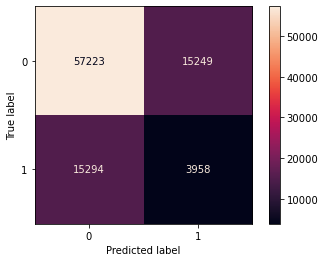

Baseline Model Training ROC Curve


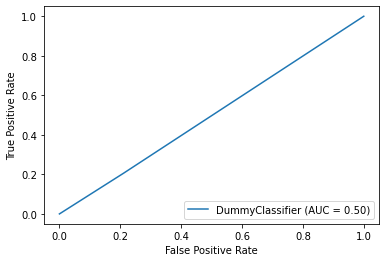

Baseline Model Test Confusion Matrix


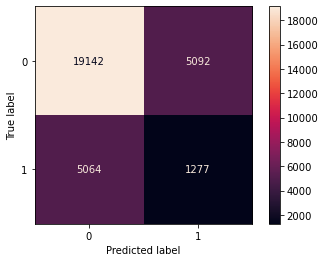

Baseline Model Test ROC Curve


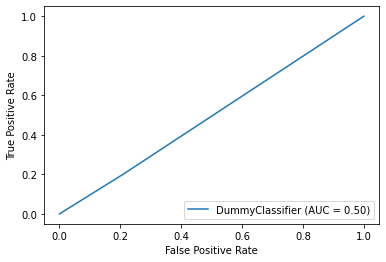

In [68]:
model_metrics(baseline, X_train_KNNI, y_train, X_test_KNNI, y_test, 'Baseline')

In [75]:
df = pd.read_csv('data/weatherAUS.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
scale_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed',
              'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
              'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Cloud9am', 'Cloud3pm']

X_train_scaled = X_train_KNNI.copy()
train_feats = X_train_scaled[scale_cols]
scaler = StandardScaler()
newvals = scaler.fit_transform(scale_feats.values)
X_train_scaled[scale_cols] = newvals

X_test_scaled = X_test_KNNI.copy()
test_feats = X_test_scaled[scale_cols]
testvals = scaler.transform(test_feats.values)
X_test_scaled[scale_cols] = testvals

In [82]:
62790/145460 * 100

43.166506256015396

In [81]:
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

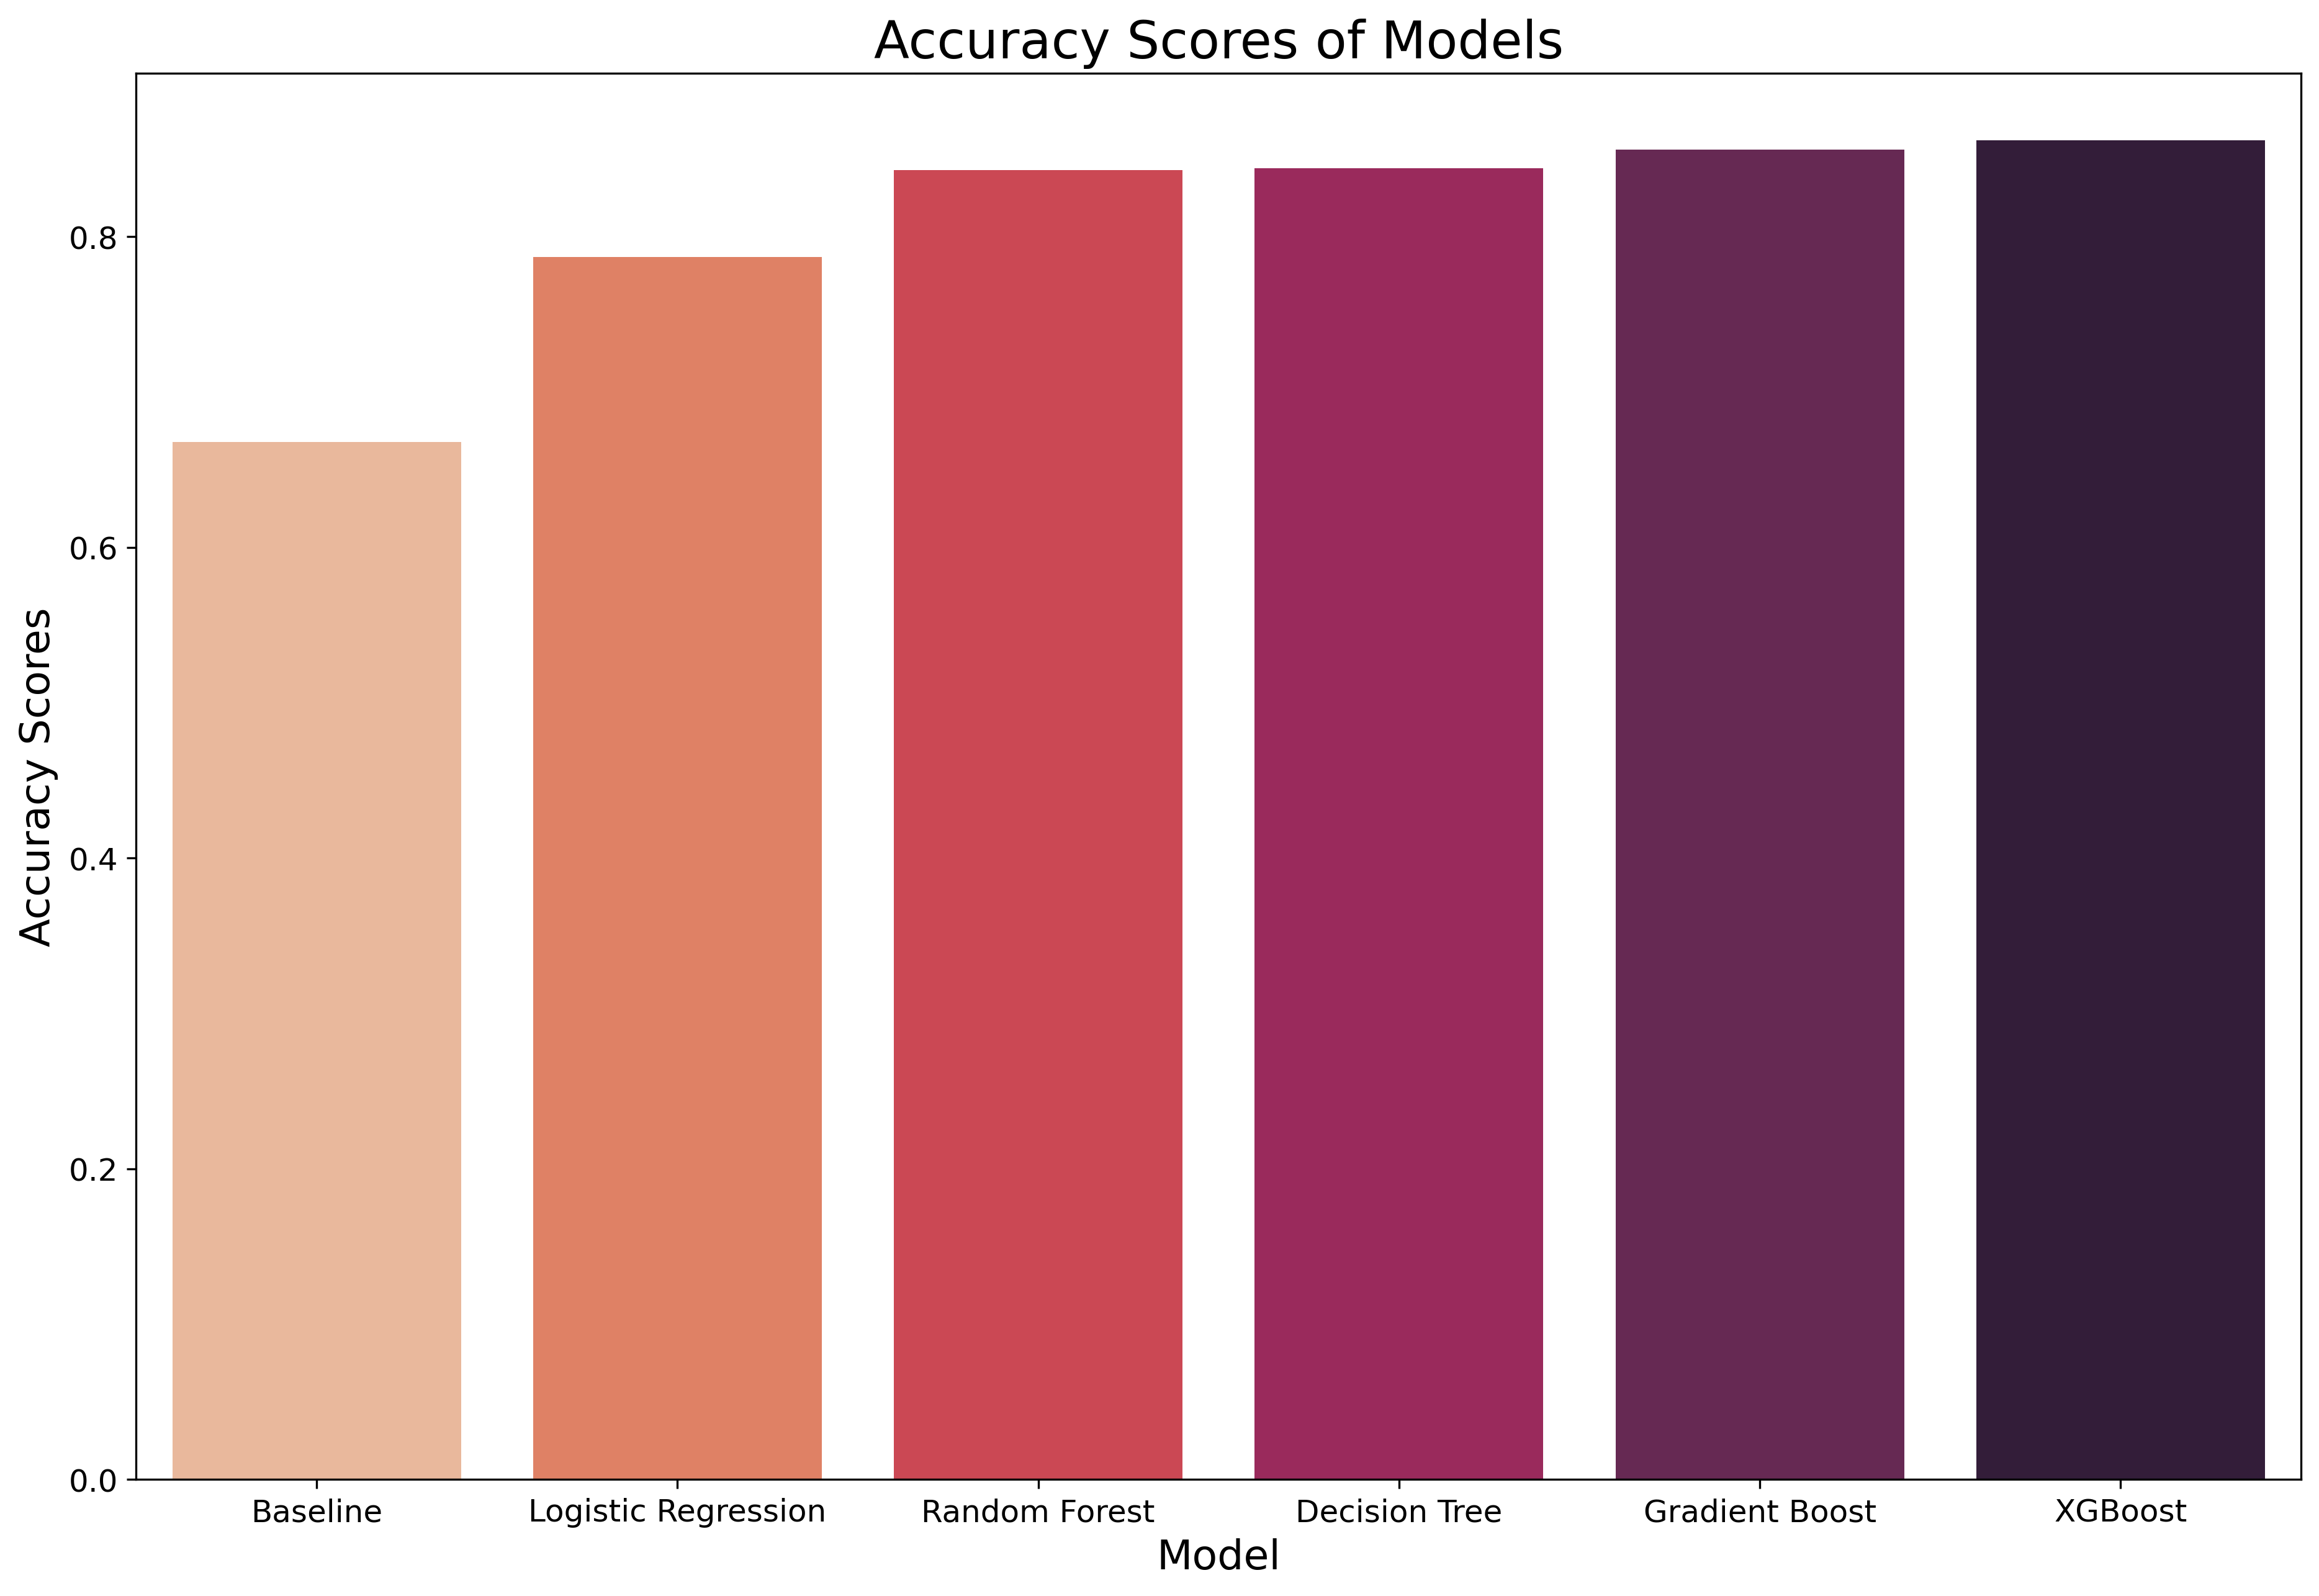

In [135]:
acc_scores = pd.DataFrame({'model':['Baseline', 'Logistic Regression', 'Random Forest',
                                    'Decision Tree', 'Gradient Boost', 'XGBoost'],
                           'accuracy':[0.668, 0.787, 0.843, 0.844, 0.856, 0.862]})

plt.figure(figsize=(15,10), dpi=300)
sns.barplot(x='model', y='accuracy', data=acc_scores, palette='rocket_r')
plt.title("Accuracy Scores of Models", fontsize=20)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Accuracy Scores', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [130]:
acc_scores = pd.DataFrame({'baseline': 0.668, 'logreg': 0.787,
                           'forest': 0.843, 'tree': 0.844,
                           'gbc': 0.856, 'xgb': 0.862})

plt.figure(figsize=(15,10), dpi=300)
sns.barplot(x=)